### **Proceso ETL de movies_dataset y credits**

Para preparar el sistema de recomendación de películas, sigo un proceso **ETL (Extracción, Transformación y Carga)** donde desanido datos, manejo valores nulos, y calculo el retorno de inversión. Así dejo el dataset listo para la API.

#### **Importo las Librerías Necesarias**

In [1]:
import pandas as pd             # Limpieza y manipulación de datos tabulares.
import json                     # Manejo de columnas anidadas en formato JSON.
import pyarrow.parquet as pq    # Almacenar y leer datos eficientemente.
import numpy as np              # Cálculos numéricos y normalización de datos.
import os                       # Gestionar archivos y directorios.
import ast                      # Convertir texto en estructuras de datos útiles.
import matplotlib.pyplot as plt # Crear gráficos para análisis exploratorio.


#### **Extracción**

Inicio con la **extracción** de los archivos `movies_dataset.csv` y `credits.csv`, los cuales contienen información detallada sobre películas y créditos asociados. 

Cargo los archivos CSV (originalmente trabajé con estos archivos, pero los convertí a Parquet para optimizar el procesamiento)
movies_csv_df = pd.read_csv('https://drive.google.com/file/d/1XTJn_UNH3aXAGgUU5I6_V-_CfjlCKoTD/view?usp=drive_link')
credits_csv_df = pd.read_csv('https://drive.google.com/file/d/1BzX8I723iJZrgcI2y58xul_ZiTdp5PDT/view?usp=drive_link')


Mis datos originales estaban en formato CSV, pero los convertí a Parquet para mejorar el rendimiento. Solo dejo esta referencia para mostrar de dónde inicié mi trabajo.

#### **Cargo los archivos Parquet originales y una copia**

In [2]:
# Cargar los archivos Parquet originales
movies_df = pd.read_parquet('Datasets/movies_dataset_formato.parquet')
credits_df = pd.read_parquet('Datasets/credits_formato.parquet')

# Guardar las copias en formato Parquet
movies_df.to_parquet('Datasets/movies_df.parquet', index=False)
credits_df.to_parquet('Datasets/credits_df.parquet', index=False)

# Obtener las rutas de los nuevos archivos
movies_df_path = 'Datasets/movies_df.parquet'
credits_df_path = 'Datasets/credits_df.parquet'

# Función para obtener el tamaño del archivo
def get_file_size(file_path):
    return os.path.getsize(file_path)

# Imprimir la ruta de cada archivo
print(f"Ruta de 'movies_df': {movies_df_path}")
print(f"Ruta de 'credits_df': {credits_df_path}")

# Imprimir el tamaño de cada archivo
print(f"Tamaño de 'movies_df': {get_file_size(movies_df_path)} bytes")
print(f"Tamaño de 'credits_df': {get_file_size(credits_df_path)} bytes")

Ruta de 'movies_df': Datasets/movies_df.parquet
Ruta de 'credits_df': Datasets/credits_df.parquet
Tamaño de 'movies_df': 17204774 bytes
Tamaño de 'credits_df': 68438680 bytes


#### **Visualización Inicial de Datos**

In [3]:
# Mostrar las primeras 5 filas del DataFrame de películas
print("* Primeras 5 filas de 'movies_dataset':")
movies_df.head()

* Primeras 5 filas de 'movies_dataset':


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,Toy Story,False,7.7,5415.0
1,False,None,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",None,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,None,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",None,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",None,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
# Mostrar las primeras 5 filas del DataFrame de créditos
print("* Primeras 5 filas de 'credits_dataset':")
credits_df.head()

* Primeras 5 filas de 'credits_dataset':


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [5]:
# Obtener estructura del DataFrame de películas (nombres de columnas, tipos de datos, valores no nulos)
print("- " * 25)
print("* Información del dataset:")
print("- " * 25)
print(movies_df.info())

- - - - - - - - - - - - - - - - - - - - - - - - - 
* Información del dataset:
- - - - - - - - - - - - - - - - - - - - - - - - - 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45460 entries, 0 to 45459
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45460 non-null  object 
 1   belongs_to_collection  4490 non-null   object 
 2   budget                 45460 non-null  object 
 3   genres                 45460 non-null  object 
 4   homepage               7778 non-null   object 
 5   id                     45460 non-null  object 
 6   imdb_id                45443 non-null  object 
 7   original_language      45449 non-null  object 
 8   original_title         45460 non-null  object 
 9   overview               44506 non-null  object 
 10  popularity             45460 non-null  float64
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 

In [6]:
# Obtener estructura del DataFrame de créditos (nombres de columnas, tipos de datos, valores no nulos)
print("- " * 20)
print("* Información del dataset:")
print("- " * 20)
print(credits_df.info())

- - - - - - - - - - - - - - - - - - - - 
* Información del dataset:
- - - - - - - - - - - - - - - - - - - - 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None


**Observaciones:**

Al revisar ambos datasets, noto que movies contiene información esencial sobre las películas, como el título, la fecha de lanzamiento, el presupuesto y los ingresos, permitiendo el análisis del desempeño financiero. Por otro lado, credits detalla el elenco y el equipo, útil para identificar actores y directores y analizar su influencia en el éxito de las películas. Ambos datasets se pueden unir mediante la columna id, proporcionando una visión integral del contexto de cada película. Seguiré con las transformaciones necesarias.

### **Transformaciones**

Para este MVP, la rapidez es clave, por lo que realizaré las siguientes transformaciones a los datos:

#### **Desanidado de las columnas que contienen diccionarios o listas**

**Para movies_df** 

In [7]:
# Definir una función para desanidar y extraer el valor deseado
def desanidar_y_extraer(df, columna, campo, nueva_columna):
    # Convertir cadenas JSON en listas o diccionarios si es necesario
    df[columna] = df[columna].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Extraer el campo específico
    df[nueva_columna] = df[columna].apply(lambda x: [item[campo] for item in x] if isinstance(x, list) else (x.get(campo) if isinstance(x, dict) else None))
    # Eliminar la columna original
    df.drop(columns=[columna], inplace=True)

# Diccionario que asocia columnas con el campo a extraer y el nombre de la nueva columna
columnas_a_procesar = {
    'belongs_to_collection': ('name', 'collection_name'),
    'production_companies': ('name', 'production_company_names'),
    'genres': ('name', 'genre_names'),
    'production_countries': ('name', 'country_names'),
    'spoken_languages': ('name', 'language_names')
}

# Iterar sobre el diccionario para aplicar el desanidado y extracción a cada columna
for columna, (campo, nueva_columna) in columnas_a_procesar.items():
    desanidar_y_extraer(movies_df, columna, campo, nueva_columna)

# Verificar los cambios
movies_df.head()

,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,tagline,title,video,vote_average,vote_count,collection_name,production_company_names,genre_names,country_names,language_names
0,False,30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,None,Toy Story,False,7.7,5415.0,Toy Story Collection,[Pixar Animation Studios],"[Animation, Comedy, Family]",[United States of America],[English]
1,False,65000000,None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,None,"[TriStar Pictures, Teitler Film, Interscope Co...","[Adventure, Fantasy, Family]",[United States of America],"[English, Français]"
2,False,0,None,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Grumpy Old Men Collection,"[Warner Bros., Lancaster Gate]","[Romance, Comedy]",[United States of America],[English]
3,False,16000000,None,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,None,[Twentieth Century Fox Film Corporation],"[Comedy, Drama, Romance]",[United States of America],[English]
4,False,0,None,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Father of the Bride Collection,"[Sandollar Productions, Touchstone Pictures]",[Comedy],[United States of America],[English]


Para desanidar los datos, implementé una función que convierte cadenas JSON en listas o diccionarios y luego extrae los campos que me interesan. Esto me permitió crear nuevas columnas como `collection_name`, `production_company_names`, `genre_names`, `country_names` y `language_names`, dejando el DataFrame más limpio y organizado para el análisis. Además, eliminé las columnas originales anidadas para mantener el conjunto de datos más manejable.

**Para credits_df**

Desanidaré las columnas `cast` y `crew` de `credits_df`, convirtiendo las cadenas de texto en listas de diccionarios. Luego, extraeré detalles clave como `id`, `nombre`, `personaje`, `trabajo` y `género`, organizándolos en DataFrames separados (`cast_df` y `crew_df`) para una estructura de datos más manejable y eficiente.

In [8]:
# Desanidar la columna 'cast'
cast_data = []
for index, row in credits_df.iterrows():
    # Convertir 'cast' de cadena a lista de diccionarios, si es necesario
    cast_list = ast.literal_eval(row['cast']) if pd.notna(row['cast']) else []
    for cast_member in cast_list:
        cast_data.append({
            'id': row['id'],
            'cast_name': cast_member.get('name'),
            'character': cast_member.get('character'),
            'gender': cast_member.get('gender')
        })

# Crear un DataFrame a partir de los datos del elenco
cast_df = pd.DataFrame(cast_data)

# Desanidar la columna 'crew'
crew_data = []
for index, row in credits_df.iterrows():
    # Convertir 'crew' de cadena a lista de diccionarios, si es necesario
    crew_list = ast.literal_eval(row['crew']) if pd.notna(row['crew']) else []
    for crew_member in crew_list:
        crew_data.append({
            'id': row['id'],
            'crew_name': crew_member.get('name'),
            'crew_job': crew_member.get('job'),
            'department': crew_member.get('department'),
            'gender': crew_member.get('gender')
        })

# Crear un DataFrame a partir de los datos del equipo
crew_df = pd.DataFrame(crew_data)

In [9]:
# Mostrar las primeras filas de los nuevos DataFrames
print("* Primeras filas de cast_df")
print(cast_df.head())
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("* Primeras filas de crew_df")
print(crew_df.head())

* Primeras filas de cast_df
    id      cast_name                character  gender
0  862      Tom Hanks            Woody (voice)       2
1  862      Tim Allen   Buzz Lightyear (voice)       2
2  862    Don Rickles  Mr. Potato Head (voice)       2
3  862     Jim Varney       Slinky Dog (voice)       2
4  862  Wallace Shawn              Rex (voice)       2
- - - - - - - - - - - - - - - - - - - - - - - - - - - -
* Primeras filas de crew_df
    id       crew_name    crew_job department  gender
0  862   John Lasseter    Director  Directing       2
1  862     Joss Whedon  Screenplay    Writing       2
2  862  Andrew Stanton  Screenplay    Writing       2
3  862      Joel Cohen  Screenplay    Writing       2
4  862    Alec Sokolow  Screenplay    Writing       0


In [10]:
# Mostrar el número de filas y columnas de ambos DataFrames
print("* Dimensiones del DataFrame 'cast_df':")
print("* Número de filas:", cast_df.shape[0])
print("* Número de columnas:", cast_df.shape[1])
print("- - - - - - - - - - - - - - - - - - - - - -")
print("* Dimensiones del DataFrame 'crew_df':")
print("* Número de filas:", crew_df.shape[0])
print("* Número de columnas:", crew_df.shape[1])

* Dimensiones del DataFrame 'cast_df':
* Número de filas: 562474
* Número de columnas: 4
- - - - - - - - - - - - - - - - - - - - - -
* Dimensiones del DataFrame 'crew_df':
* Número de filas: 464314
* Número de columnas: 5


Para desanidar las columnas `cast` y `crew`, recorrí el DataFrame `credits_df` y convertí las cadenas en listas de diccionarios. Luego, extraje información clave del elenco, como `cast_name`, `character` y `gender`, y datos del equipo técnico, como `crew_name`, `crew_job`, `department` y `gender`. Creé nuevos DataFrames (`cast_df` y `crew_df`) para organizar estos detalles, manteniendo la estructura más clara y lista para el análisis.

#### **Guardar estos nuevos Dataset 'Cast_df' y 'Crew_df'**

In [11]:
# Guardar en formato Parquet
cast_df.to_parquet('Datasets/cast_df.parquet', index=False)
crew_df.to_parquet('Datasets/crew_df.parquet', index=False)

Después de desanidar los datos de `cast` y `crew`, los guardé en formato Parquet para optimizar el almacenamiento y el rendimiento en futuras cargas. Este formato me permite manejar grandes volúmenes de datos de manera eficiente, lo que es crucial para un proyecto como este que involucra procesamiento y análisis extensivos.

#### **Reemplazar los valores nulos en las columnas revenue y budget con 0 en movies_df**

In [12]:
# Reemplazo de valores nulos en las columnas 'revenue' y 'budget' de movies_df sin el argumento inplace
movies_df['revenue'] = movies_df['revenue'].fillna(0)
movies_df['budget'] = movies_df['budget'].fillna(0)

# Verificación de los cambios realizados
print("* Valores nulos en revenue:", movies_df['revenue'].isnull().sum())
print("* Valores nulos en budget:", movies_df['budget'].isnull().sum())


* Valores nulos en revenue: 0
* Valores nulos en budget: 0


#### **Eliminar las filas donde release_date tiene valores nulos en movies_df**

In [13]:
# Eliminación de filas con valores nulos en la columna 'release_date'
movies_df = movies_df.dropna(subset=['release_date'])

# Verificación de la eliminación
print("* Valores nulos en release_date:", movies_df['release_date'].isnull().sum())
print("* Número de filas después de la eliminación:", movies_df.shape[0])


* Valores nulos en release_date: 0
* Número de filas después de la eliminación: 45376


#### **Fechas en release_date en formato AAAA-mm-dd y Crear una nueva columna release_year con el año de cada fecha**

In [14]:
# Convertir 'release_date' al formato AAAA-mm-dd
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Crear la columna 'release_year' extrayendo el año de 'release_date' y asegurando que sea un entero
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year.astype('Int64')

# Verificación de los cambios
print("* Primeras filas de release_date y release_year:")
print(movies_df[['release_date', 'release_year']].head())



* Primeras filas de release_date y release_year:
  release_date  release_year
0   1995-10-30          1995
1   1995-12-15          1995
2   1995-12-22          1995
3   1995-12-22          1995
4   1995-02-10          1995


#### **Crear una columna return que calcule el retorno de inversión usando los campos revenue y budget.**

In [15]:
# Convertir las columnas 'revenue' y 'budget' a tipo numérico, reemplazando errores con 0
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce').fillna(0)
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce').fillna(0)

# Crear la columna 'return' calculando revenue / budget, con valor 0 cuando no hay datos o budget es 0
movies_df['return'] = movies_df.apply(lambda row: row['revenue'] / row['budget'] if row['budget'] > 0 else 0, axis=1)

# Verificación de los cambios
print("* Primeras filas de revenue, budget y return:")
print(movies_df[['revenue', 'budget', 'return']].head())


* Primeras filas de revenue, budget y return:
       revenue    budget     return
0  373554033.0  30000000  12.451801
1  262797249.0  65000000   4.043035
2          0.0         0   0.000000
3   81452156.0  16000000   5.090760
4   76578911.0         0   0.000000


#### **Eliminar columnas innecesarias (video, imdb_id, adult, original_title, poster_path, y homepage) de movies_df**

In [16]:
# Eliminar columnas no utilizadas
movies_df = movies_df.drop(columns=['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage'])

# Verificación de las columnas restantes
print(f"* Columnas después de la eliminación:\n {movies_df.columns}")


* Columnas después de la eliminación:
 Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'collection_name',
       'production_company_names', 'genre_names', 'country_names',
       'language_names', 'release_year', 'return'],
      dtype='object')


#### **Limpieza de los Dataset**

####  **Movies_df**

In [17]:
# Visualizar las primeras filas y las columnas
movies_df.head()
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45376 entries, 0 to 45459
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   budget                    45376 non-null  int64  
 1   id                        45376 non-null  object 
 2   original_language         45365 non-null  object 
 3   overview                  44435 non-null  object 
 4   popularity                45376 non-null  float64
 5   release_date              45376 non-null  object 
 6   revenue                   45376 non-null  float64
 7   runtime                   45130 non-null  float64
 8   status                    45296 non-null  object 
 9   tagline                   20398 non-null  object 
 10  title                     45376 non-null  object 
 11  vote_average              45376 non-null  float64
 12  vote_count                45376 non-null  float64
 13  collection_name           4488 non-null   object 
 14  production_

#### **Convertir tipo de datos**

In [18]:
# Convertir 'id' a string si es un identificador
movies_df['id'] = movies_df['id'].astype(str)

# Convertir columnas con listas a tipo string para luego tratarlas como categorías
columns_with_lists = ['production_company_names', 'genre_names', 'country_names', 'language_names']
for col in columns_with_lists:
    movies_df[col] = movies_df[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Convertir columnas categóricas a tipo 'category'
categorical_columns = ['original_language', 'status', 'collection_name', 
                       'production_company_names', 'genre_names', 'country_names', 'language_names']
movies_df[categorical_columns] = movies_df[categorical_columns].astype('category')

# Verificación final de los tipos de datos
print("Tipos de datos después de los cambios:")
print(movies_df.dtypes)

Tipos de datos después de los cambios:
budget                         int64
id                            object
original_language           category
overview                      object
popularity                   float64
release_date                  object
revenue                      float64
runtime                      float64
status                      category
tagline                       object
title                         object
vote_average                 float64
vote_count                   float64
collection_name             category
production_company_names    category
genre_names                 category
country_names               category
language_names              category
release_year                   Int64
return                       float64
dtype: object


In [19]:
print(movies_df[['id', 'production_company_names', 'genre_names']].head())

      id                           production_company_names  \
0    862                            Pixar Animation Studios   
1   8844  TriStar Pictures, Teitler Film, Interscope Com...   
2  15602                       Warner Bros., Lancaster Gate   
3  31357             Twentieth Century Fox Film Corporation   
4  11862         Sandollar Productions, Touchstone Pictures   

                  genre_names  
0   Animation, Comedy, Family  
1  Adventure, Fantasy, Family  
2             Romance, Comedy  
3      Comedy, Drama, Romance  
4                      Comedy  


In [20]:
# Convertir columnas con listas a tipo string, separadas por comas
columns_with_lists = ['production_company_names', 'genre_names']
for col in columns_with_lists:
    movies_df[col] = movies_df[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Verificar si el cambio se aplicó correctamente
print(movies_df[['id', 'production_company_names', 'genre_names']].head())


      id                           production_company_names  \
0    862                            Pixar Animation Studios   
1   8844  TriStar Pictures, Teitler Film, Interscope Com...   
2  15602                       Warner Bros., Lancaster Gate   
3  31357             Twentieth Century Fox Film Corporation   
4  11862         Sandollar Productions, Touchstone Pictures   

                  genre_names  
0   Animation, Comedy, Family  
1  Adventure, Fantasy, Family  
2             Romance, Comedy  
3      Comedy, Drama, Romance  
4                      Comedy  



#### **valores nulos.**


                   Null Count  Percentage
original_language          11    0.024242
overview                  941    2.073783
runtime                   246    0.542137
status                     80    0.176305
tagline                 24978   55.046721
collection_name         40888   90.109309


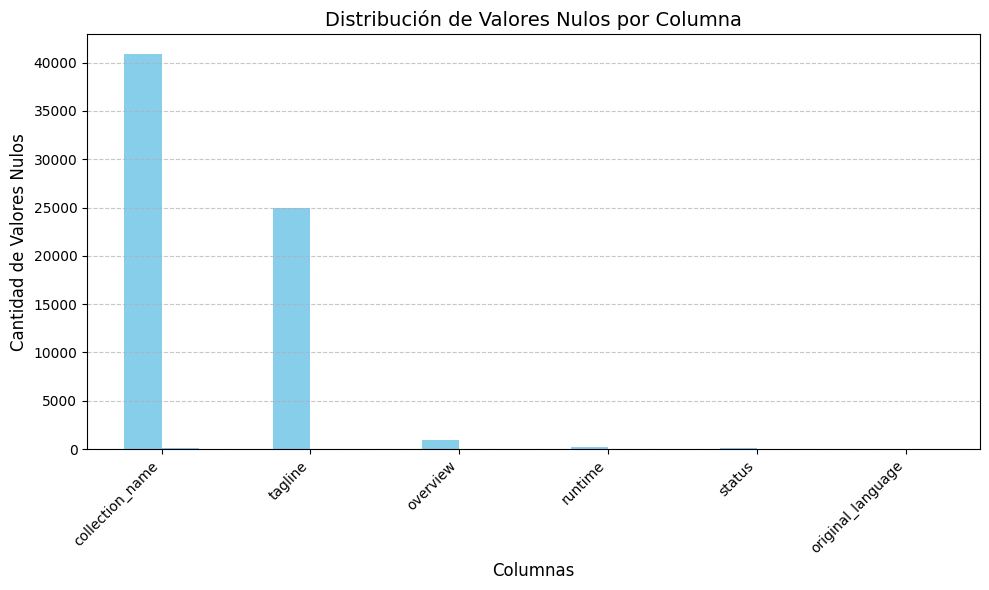

In [21]:
# Contar valores nulos en cada columna
null_counts = movies_df.isnull().sum()

# Crear un DataFrame para visualizar los resultados
null_counts_df = pd.DataFrame(null_counts, columns=['Null Count'])
null_counts_df['Percentage'] = (null_counts_df['Null Count'] / len(movies_df)) * 100

# Mostrar las columnas con valores nulos
print(null_counts_df[null_counts_df['Null Count'] > 0])

# Ajustar el tamaño de la figura y graficar la distribución de valores nulos
plt.figure(figsize=(10, 6))
null_counts_df[null_counts_df['Null Count'] > 0].sort_values(by='Null Count', ascending=False).plot(
    kind='bar', legend=False, color='skyblue', ax=plt.gca()
)
plt.title('Distribución de Valores Nulos por Columna', fontsize=14)
plt.xlabel('Columnas', fontsize=12)
plt.ylabel('Cantidad de Valores Nulos', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()  # Ajusta automáticamente el gráfico para que no se corte
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### **Eliminar las columnas**

He decidido eliminar las columnas 'collection_name' y 'tagline' debido a que presentan una alta cantidad de valores nulos. 'collection_name' tiene un 90.11 % de valores nulos, mientras que 'tagline' tiene un 55.05 %. Estas proporciones significan que gran parte de la información en estas columnas está ausente, limitando su utilidad para el análisis y modelos futuros. Por lo tanto, simplifico el dataset eliminando estas variables.


In [22]:
# Eliminar las columnas collection_name y tagline
movies_df.drop(columns=['collection_name', 'tagline'], inplace=True)

# Confirmar que las columnas han sido eliminadas
print("* Columnas restantes:")
print(movies_df.columns)

* Columnas restantes:
Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'title', 'vote_average',
       'vote_count', 'production_company_names', 'genre_names',
       'country_names', 'language_names', 'release_year', 'return'],
      dtype='object')


#### **Eliminar valores nulos (filas)**

Eliminaré los registros con valores nulos en estas columnas, ya que son cruciales para el análisis y la recomendación. Información como el idioma original y la descripción de la película aporta contexto esencial, mientras que la popularidad, la fecha de estreno y la duración son vitales para caracterizar correctamente cada película.

In [23]:
# Eliminar filas con valores nulos en las columnas especificadas
movies_df.dropna(subset=[
    'original_language', 'overview', 'popularity', 'release_date', 
    'runtime', 'status', 'title', 'vote_average', 'vote_count', 
    'production_company_names', 'country_names', 'language_names', 'release_year'
], inplace=True)

# Confirmar que se han eliminado los valores nulos
print("* Cantidad de registros después de eliminar nulos:")
print(movies_df.shape[0])


* Cantidad de registros después de eliminar nulos:
44361


#### **Eliminar duplicados**

In [24]:
# Verificar duplicados en movies_df
duplicados_movies = movies_df.duplicated().sum()
print(f"Cantidad de duplicados en movies_df: {duplicados_movies}")

Cantidad de duplicados en movies_df: 17


In [25]:
# Eliminar duplicados en movies_df (si los hay)
if duplicados_movies > 0:
    movies_df = movies_df.drop_duplicates()
    print("Duplicados eliminados en movies_df.")
else:
    print("No hay duplicados en movies_df.")

Duplicados eliminados en movies_df.


####  **Cast_df**
#### **Valores Nulos**

In [26]:
# Ver la cantidad de valores nulos por columna
print(cast_df.isnull().sum())

id           0
cast_name    0
character    0
gender       0
dtype: int64


In [27]:
cast_df

,id,cast_name,character,gender
0,862,Tom Hanks,Woody (voice),2
1,862,Tim Allen,Buzz Lightyear (voice),2
2,862,Don Rickles,Mr. Potato Head (voice),2
3,862,Jim Varney,Slinky Dog (voice),2
4,862,Wallace Shawn,Rex (voice),2
...,...,...,...,...
562469,227506,Iwan Mosschuchin,,2
562470,227506,Nathalie Lissenko,,1
562471,227506,Pavel Pavlov,,2
562472,227506,Aleksandr Chabrov,,0


In [28]:
print(f"* Hay {(cast_df['character'] == '').sum()} filas vacías en la columna 'character'")

* Hay 25782 filas vacías en la columna 'character'


In [29]:
# Eliminar registros donde 'character' es una cadena vacía
cast_df_cleaned = cast_df[cast_df['character'] != ""]

# Contar la cantidad de registros después de la limpieza
cantidad_registros = cast_df_cleaned.shape[0]
print(f"* Cantidad de registros después de eliminar cadenas vacías en 'character': {cantidad_registros}")

* Cantidad de registros después de eliminar cadenas vacías en 'character': 536692


In [30]:
# Contar filas donde 'character' es NaN o una cadena vacía
filas_vacias = cast_df['character'].isna().sum() + (cast_df['character'] == "").sum()
print(f"* Hay {filas_vacias} filas vacías en la columna 'character'")

* Hay 25782 filas vacías en la columna 'character'


In [31]:
# Contar filas donde 'character' es NaN o una cadena vacía antes de la eliminación
filas_vacias_before = cast_df['character'].isna().sum() + (cast_df['character'] == "").sum()
print(f"* Antes de la eliminación, hay {filas_vacias_before} filas vacías en la columna 'character'.")

# Eliminar filas donde 'character' es NaN o una cadena vacía
cast_df = cast_df.dropna(subset=['character'])  # Eliminar NaN
cast_df = cast_df[cast_df['character'] != ""]   # Eliminar cadenas vacías

# Contar filas donde 'character' es NaN o una cadena vacía después de la eliminación
filas_vacias_after = cast_df['character'].isna().sum() + (cast_df['character'] == "").sum()
print(f"* Después de la eliminación, hay {filas_vacias_after} filas vacías en la columna 'character'.")

* Antes de la eliminación, hay 25782 filas vacías en la columna 'character'.
* Después de la eliminación, hay 0 filas vacías en la columna 'character'.


In [32]:
# Verificar si hay caracteres inusuales en la columna 'character'
caracteres_inusuales = cast_df[cast_df['character'].str.contains(r'[^\x00-\x7F]', regex=True, na=False)]
print(f"* Hay {caracteres_inusuales.shape[0]} filas con caracteres inusuales en 'character'.")

# Mostrar algunas de estas filas si existen
if not caracteres_inusuales.empty:
    print(caracteres_inusuales.head(10))
else:
    print("No se encontraron caracteres inusuales en la columna 'character'.")

* Hay 16186 filas con caracteres inusuales en 'character'.
         id                  cast_name                     character  gender
200    9091           Raymond J. Barry   Vizepräsident Daniel Bender       2
237    9087  Clement von Franckenstein  President René Jean D'Astier       2
339     524              Dick Smothers                      Sénateur       2
688   78802         Elizabeth McGovern             Noëlle Guillaumet       1
691   78802                  Ron Sauvé            Jean-René Lefèbvre       0
1274  48750            Michel Boujenah                   André Ziman       2
1277  48750             Annie Girardot              Thénardière 1942       1
1278  48750           Philippe Léotard               Thénardier 1942       2
1281  48750                      Rufus        Thénardier 1830 / 1990       2
1282  48750           Nicole Croisille       Thénardière 1830 / 1990       0


In [33]:
# Eliminar filas con caracteres inusuales
cast_df = cast_df[~cast_df['character'].str.contains(r'[^\x00-\x7F]', regex=True, na=False)]

# Ver cuántas filas quedan ahora
print(f"* Ahora hay {cast_df.shape[0]} filas en el DataFrame 'cast_df' después de eliminar caracteres inusuales.")


* Ahora hay 520506 filas en el DataFrame 'cast_df' después de eliminar caracteres inusuales.


In [34]:
print(f"* Hay {(cast_df['cast_name'] == '').sum()} filas vacías en la columna 'cast_name'")

* Hay 0 filas vacías en la columna 'cast_name'


In [35]:
# Verificar si hay caracteres inusuales en la columna 'cast_name'
caracteres_inusuales = cast_df[cast_df['cast_name'].str.contains(r'[^\x00-\x7F]', regex=True, na=False)]
print(f"* Hay {caracteres_inusuales.shape[0]} filas con caracteres inusuales en 'cast_name'.")

# Mostrar algunas de estas filas si existen
if not caracteres_inusuales.empty:
    print(caracteres_inusuales.head(10))
else:
    print("No se encontraron caracteres inusuales en la columna 'cast_name'.")


* Hay 24073 filas con caracteres inusuales en 'cast_name'.
        id          cast_name                        character  gender
145  11860       Miriam Colón                             Rosa       1
147  11860  Valérie Lemercier                          Martine       1
159  11860     François Genty                Make-Up Assistant       0
161  11860        Inés Sastre                            Model       1
212    710       Tchéky Karyo  Defense Minister Dmitri Mishkin       2
389   4584    Emilie François                Margaret Dashwood       0
493   9691   Germán Legarreta                     Kid in plaza       2
514  16420        Irène Jacob                        Desdemona       1
517  16420          Indra Ové                           Bianca       0
539  17015       Ciarán Hinds      Captain Frederick Wentworth       2


In [36]:
# Eliminar filas con caracteres inusuales en 'cast_name'
cast_df = cast_df[~cast_df['cast_name'].str.contains(r'[^\x00-\x7F]', regex=True, na=False)]
print(f"* Después de eliminar, quedan {cast_df.shape[0]} filas en el DataFrame.")

* Después de eliminar, quedan 496433 filas en el DataFrame.


Realicé un proceso exhaustivo de limpieza en el DataFrame `cast_df` para eliminar valores nulos en la columna `'character'`, utilizando diversas técnicas, ya que inicialmente no se detectaban. Decidí eliminar los registros vacíos en esta columna porque no aportan información útil y pueden afectar la calidad de los resultados. Esto me permite trabajar con un conjunto de datos más robusto y confiable, dejando **520,505 filas** restantes. Ahora procederé a verificar y eliminar posibles filas duplicadas antes de guardar el DataFrame limpio en un archivo Parquet.

#### **Eliminar duplicados**

In [37]:
# Verificar duplicados en cast_df
duplicados_cast = cast_df.duplicated().sum()
print(f"Cantidad de duplicados en cast_df: {duplicados_cast}")

Cantidad de duplicados en cast_df: 425


In [38]:
# Eliminar duplicados en cast_df (si los hay)
if duplicados_cast > 0:
    cast_df = cast_df.drop_duplicates()
    print("Duplicados eliminados en cast_df.")
else:
    print("No hay duplicados en cast_df.")

Duplicados eliminados en cast_df.


Decidí eliminar los registros duplicados en mi DataFrame porque pueden distorsionar el análisis y dar lugar a resultados sesgados. Al hacerlo, aseguro que cada entrada en el conjunto de datos sea única, lo que mejora la calidad de los resultados de mis modelos y la integridad de mi análisis.

#### **Crew_df**

In [39]:
crew_df

,id,crew_name,crew_job,department,gender
0,862,John Lasseter,Director,Directing,2
1,862,Joss Whedon,Screenplay,Writing,2
2,862,Andrew Stanton,Screenplay,Writing,2
3,862,Joel Cohen,Screenplay,Writing,2
4,862,Alec Sokolow,Screenplay,Writing,0
...,...,...,...,...,...
464309,67758,Richard McHugh,Original Music Composer,Sound,0
464310,67758,João Fernandes,Director of Photography,Camera,2
464311,227506,Yakov Protazanov,Director,Directing,0
464312,227506,Joseph N. Ermolieff,Producer,Production,2


#### **Valores Nulos**

In [40]:
# Ver la cantidad de valores nulos por columna
valores_nulos = crew_df.isnull().sum() + (crew_df == "").sum()
print(valores_nulos)


id            0
crew_name     0
crew_job      0
department    0
gender        0
dtype: int64


#### **Registros duplicados**

In [41]:
# Contar la cantidad de registros duplicados
cantidad_duplicados = crew_df.duplicated().sum()
print(f"Cantidad de registros duplicados: {cantidad_duplicados}")

Cantidad de registros duplicados: 608


In [42]:
# Eliminar registros duplicados
crew_df_cleaned = crew_df.drop_duplicates()

# Contar la cantidad de registros después de eliminar duplicados
cantidad_registros_despues_duplicados = crew_df_cleaned.shape[0]
print(f"Cantidad de registros después de eliminar duplicados: {cantidad_registros_despues_duplicados}")


Cantidad de registros después de eliminar duplicados: 463706


In [43]:
# Convertir las columnas 'id' a tipo int y asegurarse de que 'revenue' no tenga valores nulos
cast_df['id'] = cast_df['id'].astype(int)
movies_df['id'] = movies_df['id'].astype(int)

# Eliminar duplicados en cast_df para evitar contar la misma película varias veces
cast_df = cast_df.drop_duplicates(subset=['id', 'cast_name'])

# Opcional: Puedes revisar los valores extremos de 'revenue'
# Mostrar las estadísticas descriptivas para detectar outliers
print(movies_df['revenue'].describe())


count    4.434400e+04
mean     1.148957e+07
std      6.511207e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64


El resumen estadístico de la columna `revenue` muestra que hay 44,344 entradas, con un ingreso promedio de aproximadamente 11.49 millones, aunque la mayoría tiene ingresos de 0. Esto indica una gran variabilidad en los ingresos, con algunas películas generando hasta casi 2.79 mil millones.

#### **Guardar los Datasets después de las transformaciones**

In [44]:
# Asegúrate de que los DataFrames tienen los nombres correctos
# (Reemplaza estos DataFrames con los datos que ya has procesado)
# movies_df, credits_df, crew_df, cast_df deben existir previamente en tu código

# Volver a guardar los DataFrames con los nombres correctos
movies_df.to_parquet('Datasets/movies_df.parquet', index=False)
credits_df.to_parquet('Datasets/credits_df.parquet', index=False)
crew_df.to_parquet('Datasets/crew_df.parquet', index=False)
cast_df.to_parquet('Datasets/cast_df.parquet', index=False)

# Definir las rutas de los archivos
ruta_movies = 'Datasets/movies_df.parquet'
ruta_credits = 'Datasets/credits_df.parquet'
ruta_crew = 'Datasets/crew_df.parquet'
ruta_cast = 'Datasets/cast_df.parquet'

# Función para obtener y mostrar el tamaño del archivo en MB
def mostrar_tamaño_archivo(ruta):
    tamaño = os.path.getsize(ruta) / (1024 * 1024)  # Conversión a MB
    print(f"* El archivo '{os.path.basename(ruta)}' pesa aproximadamente {tamaño:.2f} MB.")

# Obtener y mostrar el tamaño de cada archivo
for ruta in [ruta_movies, ruta_credits, ruta_crew, ruta_cast]:
    mostrar_tamaño_archivo(ruta)

# Confirmación de que los archivos se han guardado correctamente
print("* Archivos Parquet guardados nuevamente con éxito.")

* El archivo 'movies_df.parquet' pesa aproximadamente 12.27 MB.
* El archivo 'credits_df.parquet' pesa aproximadamente 65.27 MB.
* El archivo 'crew_df.parquet' pesa aproximadamente 5.62 MB.
* El archivo 'cast_df.parquet' pesa aproximadamente 10.51 MB.
* Archivos Parquet guardados nuevamente con éxito.


Al incluir los DataFrames cast_df y crew_df, me aseguro de que toda la información relevante del proyecto se guarda y está disponible para análisis futuros. Verificar el tamaño de los archivos también permite monitorizar el uso de espacio y confirmar que los datos han sido gestionados correctamente, lo que es fundamental en el manejo de grandes conjuntos de datos.